In [306]:
%precision 3

import numpy as np
import pandas as pd
from pyinform import utils, transfer_entropy
from dtw import dtw

from matplotlib import pyplot as plt
from matplotlib import ticker, collections, colors
plt.style.use("minimal")

In [13]:
session = 4
datafile_path = f"data/Test{session}.tsv"

metadata_header_lines = 9

events = pd.read_csv(datafile_path, sep = "\t", header = None, names = ("Type", "Name", "Frame", "Time"), skiprows=metadata_header_lines, on_bad_lines = "skip").drop(columns = ["Type"])

amount_trials = 1 + len(events[events["Name"] == "Trial"])
print(f"""[INFO] found {amount_trials} trial{"s" if amount_trials > 1 else ""}""")

marker_names = pd.read_csv(datafile_path, sep = "\t", header = None, skiprows=metadata_header_lines + len(events), nrows = 1).loc[0, 1:].values
markers = list(sorted(set([name[2:] for name in marker_names])))
print(f"""[INFO] found {len(markers)} markers: {", ".join(markers)}""")

data = pd.read_csv(datafile_path, sep = "\t", header = metadata_header_lines + len(events) + 2, usecols=lambda name: "Unnamed" not in name)

data = data.set_index(["Frame", "Time"])
data.columns = data.columns.str.split("_", expand = True)
data = data.stack(0)
data.columns = data.columns.str.split(" ", expand = True)
data = data.stack(1)
data.index = data.index.rename(["Frame", "Time", "Subject", "Axis"])
data = data.reset_index()

for frame, event_name in events.set_index("Frame")["Name"].items():
    data.loc[data["Frame"] == frame, "Event"] = event_name

data.insert(2, "Trial", ((data["Event"] == "Trial") & (data["Event"].fillna(0) != data["Event"].fillna(0).shift())).cumsum() + 1)

trials = []
for trial, subset in data.groupby("Trial"):
    participants = []
    for subject, subset in subset.groupby("Subject"):
        marker_collection = []
        for marker in markers:
            pos_data = subset[["Frame", "Time", "Axis", marker]].pivot(index = ["Frame", "Time"], columns = ["Axis"], values = marker)
            pos_data = pos_data[[dimension + "_Raw" for dimension in "XYZ"]] = pos_data.replace(0, np.nan)
            pos_data[[dimension for dimension in "XYZ"]] = pos_data[[dimension for dimension in "XYZ"]].interpolate()
            marker_collection.append(pos_data.reset_index())
        participants.append(pd.Series(marker_collection, name = "Marker", index = markers))
    trials.append(pd.Series(participants, name = "Participant", index = ["A", "B"]))
dataset = pd.Series(data = trials, index = range(1, len(trials) + 1), name = "Trial")

# dataset[1]["A"]["Elbow"]

[INFO] found 4 trials
[INFO] found 8 markers: Biceps, Elbow, Hand, HipLeft, HipRight, ShoulderLeft, ShoulderRight, Wrist


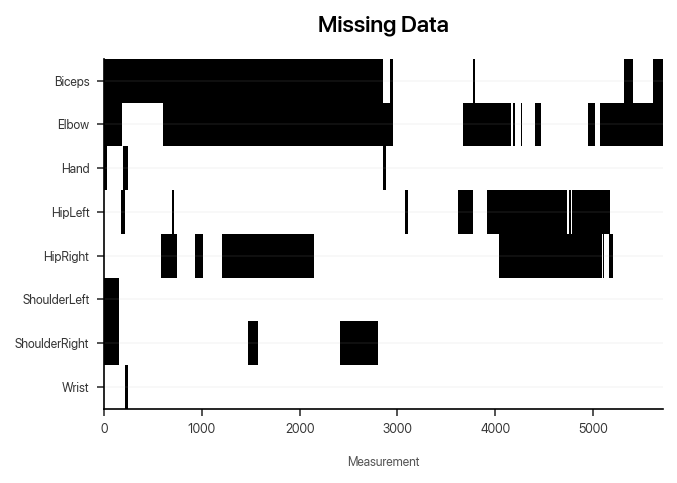

In [143]:
def assess_missing(trial):
    a = []
    for marker in markers:
        subset = pd.concat([dataset[trial]["A"][marker], dataset[trial]["B"][marker]])
        a.append(subset.isna().any(axis = 1))
    plt.imshow(np.where(np.array(a).astype(int) > 0.5, 1, 0.15), interpolation = "none", aspect = "auto", cmap = "binary")
    plt.yticks(range(len(markers)), markers)
    plt.xlabel("Measurement")
    plt.title("Missing Data\n")
    plt.tight_layout()

assess_missing(3)

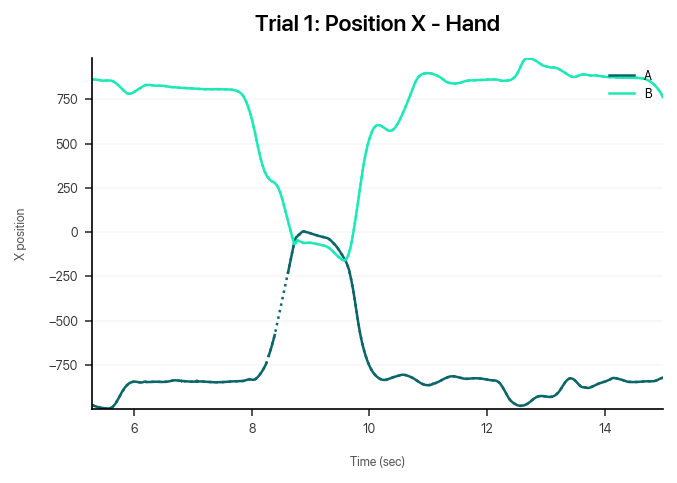

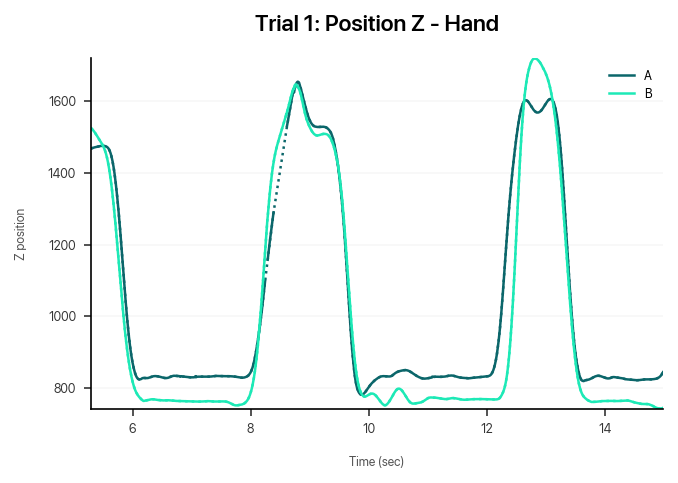

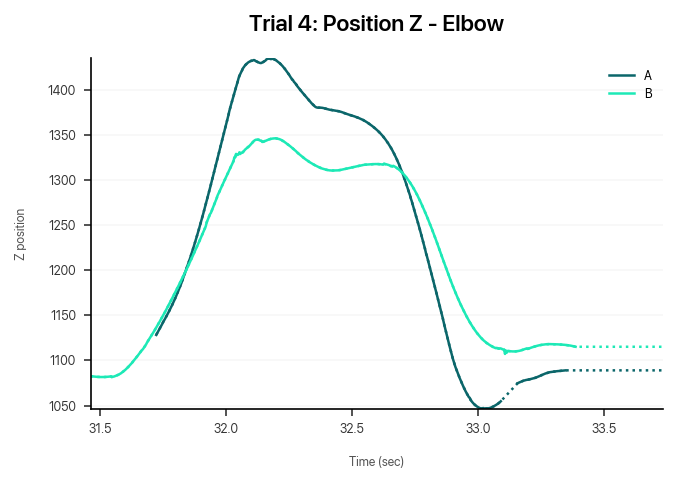

In [18]:
def plot_position(trial, marker, axis):
    plt.figure()
    for subject, subset in dataset[trial].items():
        plt.plot(
            subset[marker]["Time"], 
            subset[marker][axis + "_Raw"],
            linewidth = 1.2, 
            label = subject, 
            color = dict(A = "C0", B = "C1")[subject]
        )
        plt.plot(
            subset[marker]["Time"], 
            subset[marker][axis], 
            linewidth = 1.2, 
            linestyle = ":", 
            color = dict(A = "C0", B = "C1")[subject]
        )
    plt.margins(x = 0, y = 0)
    plt.title(f"Trial {trial}: Position {axis} - {marker}\n")
    plt.xlabel("Time (sec)")
    plt.ylabel(f"{axis} position")
    plt.legend(loc = "upper right")
    plt.tight_layout()

plot_position(trial = 1, marker = "Hand", axis = "X")
plot_position(trial = 1, marker = "Hand", axis = "Z")
plot_position(trial = 4, marker = "Elbow", axis = "Z")

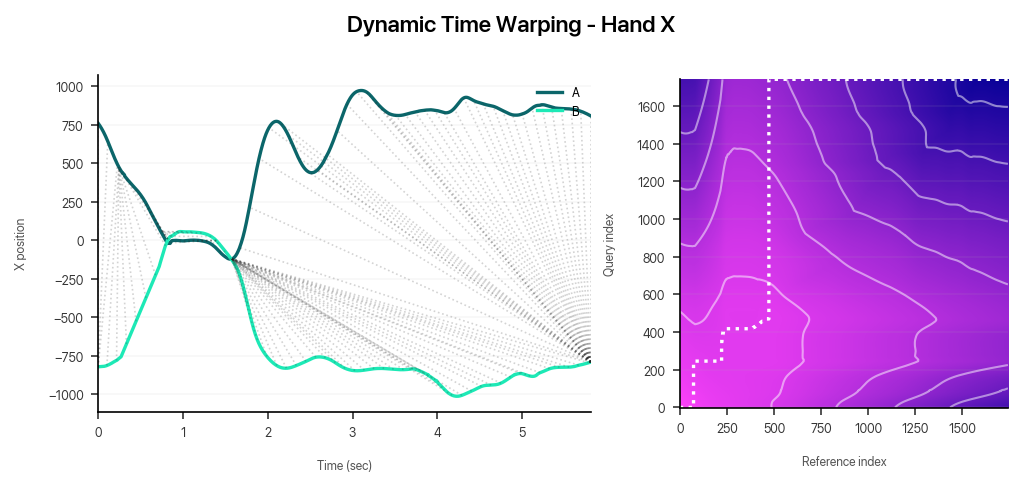

In [316]:
def plot_dynamic_time_warping(trial, marker, axis):
    reference = dataset[trial]["A"][marker][axis]
    query = dataset[trial]["B"][marker][axis]
    d = dtw(reference, query, keep_internals=True)

    fig, axes = plt.subplots(ncols=2, width_ratios=(0.6, 0.4), figsize = (6.8, 3.2))
    # d.plot(type = "twoway")
    axes[0].plot(range(len(query)), query, label = "A")
    axes[0].plot(range(len(reference)), reference, label = "B")

    axes[0].xaxis.set_major_locator(ticker.MultipleLocator(300))
    axes[0].xaxis.set_major_formatter(lambda val, idx: round(val / 300))
    axes[0].set_xlabel("Time (sec)")
    axes[0].set_ylabel(f"{axis} position")
    col = []
    for i in np.linspace(0, len(d.index1) - 1, num = 100).astype(int):
        col.append([
            (d.index1[i], reference[d.index1[i]]),
            (d.index2[i], query[d.index2[i]])
        ])
    axes[0].add_collection(collections.LineCollection(col, linestyles=":", linewidths = 0.8, colors = (0.15, 0.15, 0.15), alpha = 0.2))
    axes[0].margins(x = 0, y = 0.05)
    axes[0].legend(loc = "upper right")

    cmap = colors.LinearSegmentedColormap.from_list("deep", ["#FF42FB", "#0B0299"], N = 256)
    axes[1].imshow(d.costMatrix.T, origin="lower", cmap = cmap, interpolation = "none")
    axes[1].contour(d.costMatrix.T, colors = "white", linewidths = 1, alpha = 0.5)
    axes[1].plot(d.index2, d.index1, color="white", linestyle = ":")
    axes[1].set_xlabel("Reference index")
    axes[1].set_ylabel("Query index")
    fig.suptitle(f"Dynamic Time Warping - {marker} {axis}\n", fontsize = 11, fontweight = 600)
    plt.tight_layout()

plot_dynamic_time_warping(trial = 2, marker = "Hand", axis = "X")
# plot_dynamic_time_warping(trial = 2, marker = "Elbow", axis = "Z")

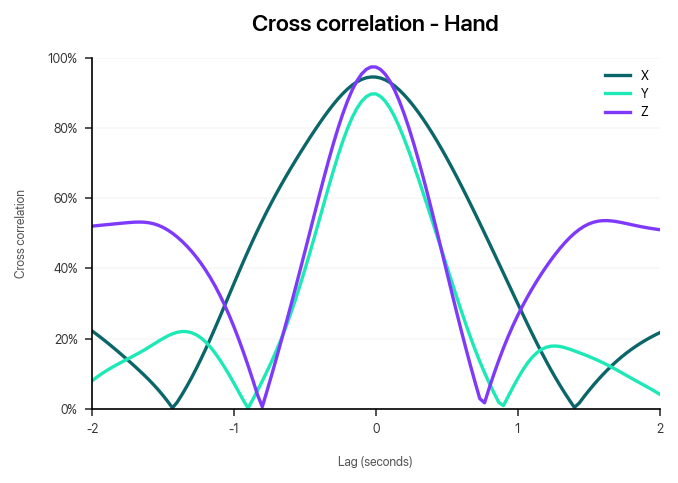

In [261]:
def plot_cross_correlation(trial, marker, lags = np.arange(-600, 600 + 1, 10)):
    plt.figure()
    for axis in "XYZ":
        cross_corrs = [abs(dataset[trial]["A"][marker][axis].corr(dataset[trial]["B"][marker][axis].shift(lag))) for lag in lags]
        plt.plot(lags, cross_corrs, label = f"{axis}")
    plt.xlabel("Lag (seconds)")
    plt.ylabel("Cross correlation")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(300))
    plt.gca().xaxis.set_major_formatter(lambda val, idx: round(val / 300))
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.title(f"Cross correlation - {marker}\n")
    plt.margins(x = 0, y = 0.1)
    plt.ylim((0, 1))
    plt.legend(loc = "upper right")
    plt.tight_layout()

plot_cross_correlation(trial = 1, marker = "Hand")

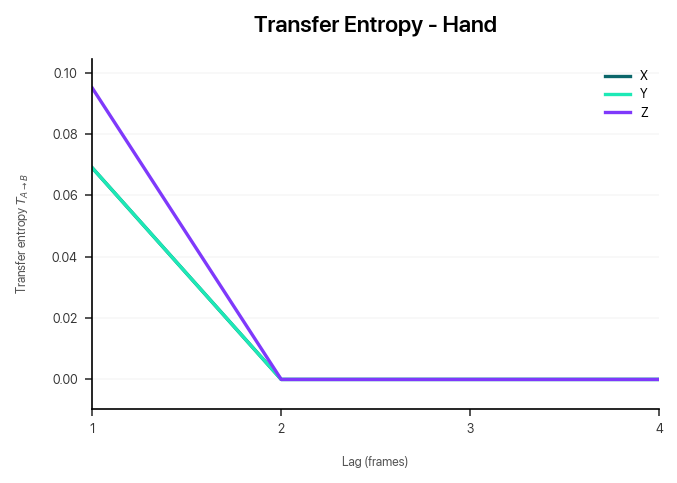

In [129]:
def plot_transfer_entropy(trial, marker, lags = np.arange(1, 5)):
    plt.figure()
    for axis in "XYZ":
        downsample_scale = 100
        plt.plot(lags, [transfer_entropy(utils.coalesce_series(dataset[trial]["A"][marker][axis][::downsample_scale])[0], utils.coalesce_series(dataset[trial]["B"][marker][axis][::downsample_scale])[0], k = lag) for lag in lags], label = f"{axis}")
    plt.xlabel("Lag (frames)")
    plt.ylabel(r"Transfer entropy $T_{A \rightarrow B}$")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(f"Transfer Entropy - {marker}\n")
    plt.margins(x = 0, y = 0.1)
    plt.legend(loc = "upper right")
    plt.tight_layout()

plot_transfer_entropy(trial = 1, marker = "Hand")

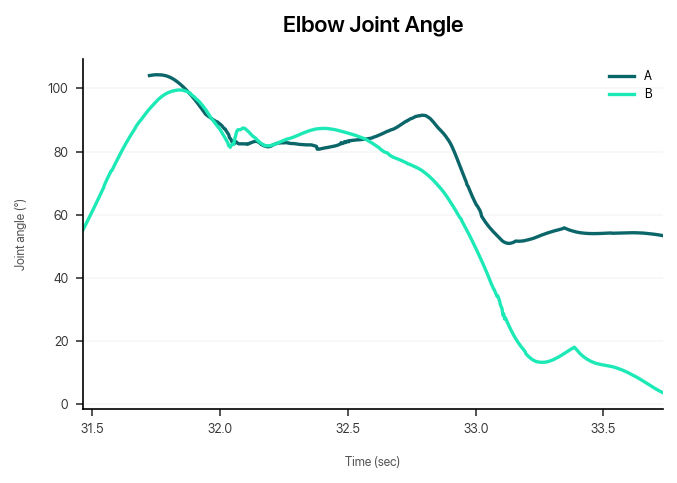

In [65]:
def calc_angle(datasets):
    # df = pd.DataFrame(index = data.index)
    diff1 = datasets[0] - datasets[1]
    line1 = (diff1).divide(np.linalg.norm(diff1.values, axis = 1), axis = 0)
    diff2 = datasets[1] - datasets[2]
    line2 = (diff2).divide(np.linalg.norm(diff2.values, axis = 1), axis = 0)

    return np.degrees(np.arccos(np.clip(np.sum(line1.values * line2.values, axis = 1), -1, 1)))

def plot_angles(trial, markers):
    markers = list(markers)
    for participant in "AB":
        datasets = [dataset[trial][participant][marker][["X", "Y", "Z"]] for marker in markers]
        plt.plot(dataset[trial][participant][markers[0]]["Time"], calc_angle(datasets), label = participant)
    plt.title("Elbow Joint Angle\n")
    plt.xlabel("Time (sec)")
    plt.ylabel("Joint angle (°)")
    plt.margins(x=0)
    plt.legend()
    plt.tight_layout()

plot_angles(trial = 4, markers = ("ShoulderRight", "Elbow", "Hand"))

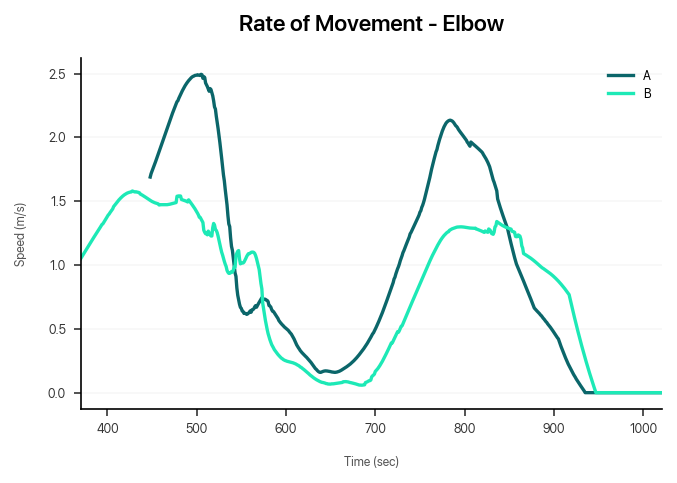

In [320]:
def calculate_velocity(data):
    data[["dX", "dY", "dZ"]] = data[["X", "Y", "Z"]].values - data[["X", "Y", "Z"]].shift(1).values
    data["v"] = data.apply(lambda vals: np.sqrt(
        vals["dX"]**2 + 
        vals["dY"]**2 + 
        vals["dZ"]**2)
    , axis = 1)
    data["v"] = 300 * data["v"].rolling(30).mean() / 1000
    return data["v"]

def plot_velocity(trial, marker):
    plt.figure()
    for participant in "AB":
        plt.plot(calculate_velocity(dataset[trial][participant][marker]), label = participant)
    plt.title(f"Rate of Movement - {marker}\n")
    plt.xlabel("Time (sec)")
    plt.ylabel("Speed (m/s)")
    plt.margins(x=0)
    plt.legend()
    plt.tight_layout()

# plot_velocity(trial = 4, marker = "Hand")
plot_velocity(trial = 4, marker = "Elbow")